# Sarcasm dataset loading & preprocessing

In [1]:
!wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
!mkdir ../ch06
!mv sarcasm.json ../ch06

In [2]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [3]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [5]:
with open("../ch06/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [6]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [7]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Embedding을 사용해 빈정거림 감지기 만들기

In [9]:
import numpy as np      # numpy 타입으로 변경

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

- Embedding layer

    초기에 벡터의 좌표가 완전히 랜덤하게 설정되고, 훈련 과정에서 Backpropagation을 사용해 학습  

    훈련이 끝나면 임베딩은 단어 사이의 유사성을 인코딩하기 때문에 단어의 벡터 방향 기반으로 비슷한 단어를 식별한다.
    
    초기화시 어휘 사전 크기, 임베딩 차원 지정을 지정해야 한다.

- GlobalAveragePooling1D

    임베딩 차원을 평균하여 고정 길이의 출력 벡터를 만든다.

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 4s 5ms/step - loss: 0.6811 - accuracy: 0.5597 - val_loss: 0.6588 - val_accuracy: 0.5729
Epoch 2/30
719/719 [==============================] - 3s 4ms/step - loss: 0.5489 - accuracy: 0.7295 - val_loss: 0.4726 - val_accuracy: 0.7840
Epoch 3/30
719/719 [==============================] - 3s 4ms/step - loss: 0.3883 - accuracy: 0.8331 - val_loss: 0.4310 - val_accuracy: 0.7951
Epoch 4/30
719/719 [==============================] - 3s 5ms/step - loss: 0.3247 - accuracy: 0.8630 - val_loss: 0.4220 - val_accuracy: 0.8043
Epoch 5/30
719/719 [==============================] - 3s 4ms/step - loss: 0.2889 - accuracy: 0.8794 - val_loss: 0.4226 - val_accuracy: 0.8086
Epoch 6/30
719/719 [==============================] - 5s 7ms/step - loss: 0.2613 - accuracy: 0.8940 - val_loss: 0.4398 - val_accuracy: 0.8070
Epoch 7/30
719/719 [==============================] - 4s 6ms/step - loss: 0.2399 - accuracy: 0.9018 - val_loss: 0.4458 - val_accuracy: 0.8072
Epoch 

### 훈련 정확도와 검증 정확도

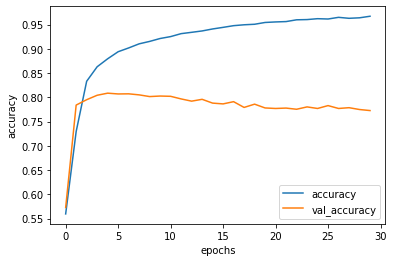

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### 훈련 Loss와 검증 Loss

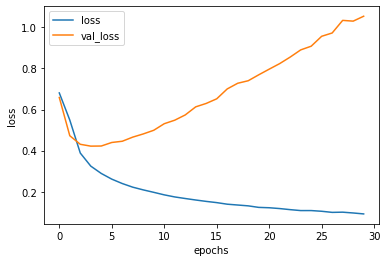

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

언어의 예측 불가능한 성질 때문에 과대적합 현상은 자연어 처리 모델에서 흔히 관측된다.

# 언어 모델의 Overfitting 줄이기

### 학습률 조정하기

과대적합을 일으키는 가장 큰 요소 → Optimizer 의 학습률이 너무 높은 경우 = 신경망이 너무 빠르게 학습  

Adam optimizer의 학습률 : 0.001 → 0.0001으로 변경

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100, validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 5s 6ms/step - loss: 0.6894 - accuracy: 0.5503 - val_loss: 0.6851 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 5ms/step - loss: 0.6857 - accuracy: 0.5596 - val_loss: 0.6828 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 5s 6ms/step - loss: 0.6844 - accuracy: 0.5596 - val_loss: 0.6816 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 3s 5ms/step - loss: 0.6832 - accuracy: 0.5596 - val_loss: 0.6801 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6815 - accuracy: 0.5596 - val_loss: 0.6782 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6789 - accuracy: 0.5596 - val_loss: 0.6751 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6745 - accuracy: 0.5597 - val_loss: 0.6708 - val_accuracy: 0.5697

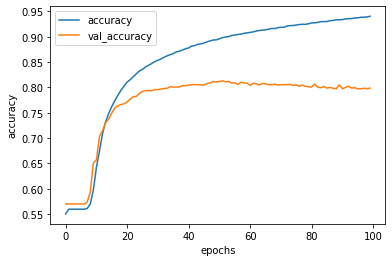

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

낮은 학습률 때문에 처음 10번의 epoch 동안은 신경망이 학습하지 않는 것처럼 보인다.  

하지만 그 이후부터 빠르게 학습하기 시작한다.

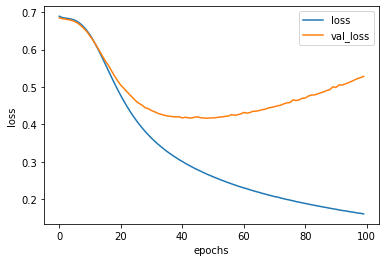

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

val_loss 곡선이 학습률 조정전과 유사한 Overfitting 곡선 양상을 보이지만 훨씬 느리게 발생하고, 곡선이 급격하지 않다.  

학습률 = 0.001일 때 Epoch 30번에 해당하는 val_loss = 1.05  
학습률 = 0.0001일 때 Epoch 30번에 해당하는 val_loss = 0.45  

→ 신경망이 좋은 정확도에 도달하기까지 더 오래 걸리지만 val_loss는 더 낮으므로 결과를 더 확신할 수 있다.

### 어휘 사전 크기 바꾸기

tokenizer 객체의 word_counts 속성을 사용하면 단어의 빈도 확인 가능  

단어의 순서는 데이터셋에 등장하는 순서대로 결정

In [19]:
wc = tokenizer.word_counts    # OrderedDict 반환됨
print(wc)

OrderedDict([('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78), ('black', 230), ('code', 19), ('minority', 12), ('shoppers', 2), ('roseanne', 3), ('revival', 10), ('catches', 10), ('thorny', 3), ('political', 73), ('mood', 13), ('better', 100), ('worse', 34), ('mom', 163), ('starting', 37), ('fear', 39), ('sons', 35), ('web', 16), ('series', 53), ('closest', 5), ('thing', 126), ('will', 484), ('grandchild', 2), ('boehner', 26), ('just', 501), ('wants', 120), ('wife', 73), ('listen', 21), ('not', 634), ('come', 92), ('alternative', 13), ('debt', 23), ('reduction', 4), ('ideas', 35), ('j', 41), ('k', 39), ('rowling', 5), ('wishes', 33), ('snape', 2), ('happy', 51), ('birthday', 57), ('magical', 25), ('way', 239), ('advancing', 2), ('worlds', 79), ('women', 289), ('fascinating', 3), ('case', 77), ('eating', 64), ('lab', 8), ('grown', 17), ('meat', 25), ('ceo', 56), ('send', 33), ('kids', 164), ('school', 207), ('work', 168), ('company', 78), ('top',

단어 빈도의 역순으로 정렬

In [20]:
from collections import OrderedDict

newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
print(newlist)

OrderedDict([('new', 1318), ('trump', 1117), ('man', 1075), ('not', 634), ('just', 501), ('will', 484), ('one', 469), ('year', 440), ('report', 434), ('area', 421), ('donald', 407), ('day', 398), ('u', 398), ('s', 392), ('can', 387), ('says', 385), ('woman', 378), ('first', 376), ('time', 365), ('like', 356), ('no', 352), ('get', 346), ('old', 332), ('trumps', 331), ('off', 326), ('now', 325), ('life', 319), ('obama', 317), ('people', 311), ('house', 290), ('women', 289), ('white', 281), ('back', 278), ('still', 276), ('make', 275), ('clinton', 264), ('5', 260), ('world', 251), ('americans', 246), ('years', 240), ('way', 239), ('family', 231), ('black', 230), ('study', 225), ('gop', 218), ('best', 215), ('bill', 211), ('american', 208), ('school', 207), ('police', 206), ('watch', 206), ('3', 205), ('show', 205), ('really', 200), ('president', 198), ('home', 196), ('last', 194), ('video', 194), ('finds', 194), ('death', 193), ('cant', 193), ('know', 193), ('10', 192), ('things', 191), (

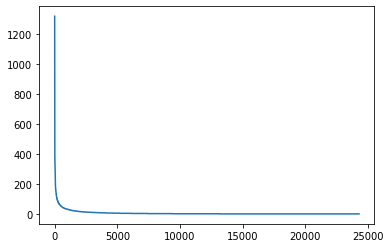

In [21]:
xs = []     # 항목의 순서
ys = []     # 빈도수
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.show()

위의 결과를 보면 많이 사용되는 단어는 소수이고, 대부분의 단어는 매우 적게 사용된 것을 알 수 있다.

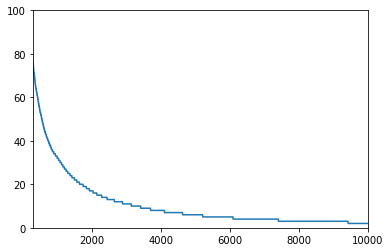

In [22]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

어휘 사전의 80%에 해당하는 2,000 ~ 10,000 사이에 있는 단어를 살펴보면 전체 말뭉치에서 20번 이하로 사용되는 것을 알 수 있다.

In [23]:
vocab_size = 2000

In [24]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 3s 3ms/step - loss: 0.6804 - accuracy: 0.5613 - val_loss: 0.6573 - val_accuracy: 0.6139
Epoch 2/30
719/719 [==============================] - 2s 3ms/step - loss: 0.5783 - accuracy: 0.6983 - val_loss: 0.5215 - val_accuracy: 0.7390
Epoch 3/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4710 - accuracy: 0.7773 - val_loss: 0.4779 - val_accuracy: 0.7611
Epoch 4/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4361 - accuracy: 0.7903 - val_loss: 0.4631 - val_accuracy: 0.7706
Epoch 5/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4196 - accuracy: 0.7987 - val_loss: 0.4606 - val_accuracy: 0.7738
Epoch 6/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4105 - accuracy: 0.8035 - val_loss: 0.4620 - val_accuracy: 0.7789
Epoch 7/30
719/719 [==============================] - 2s 3ms/step - loss: 0.4053 - accuracy: 0.8067 - val_loss: 0.4665 - val_accuracy: 0.7722
Epoch 

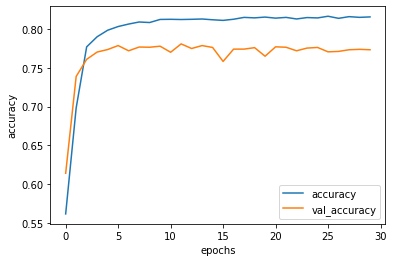

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

두 곡선은 발산하지 않고 서로 가깝게 놓여 있으므로 대부분의 Overfitting을 제거했다고 볼 수 있다.

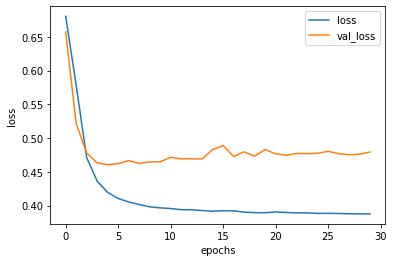

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

val_loss 가 증가하지만 이전보다 훨씬 느리다.  

따라서 어휘 사전 크기를 줄이면 빈도가 낮아 훈련 세트에만 있을 가능성이 높은 단어에 과대적합되는 것을 방지할 수 있다.  

어휘 사전 크기가 너무 작아도 Overfitting 될 수 있으니, 둘 사이의 균형을 찾아야 한다.

### 임베딩 차원 바꾸기

어휘 사전 크기의 네제곱근을 사용하는 것이 좋다.   

2000의 네제곱근 = 6.687 → 임베딩 차원 = 7 로 설정

In [30]:
embedding_dim = 7

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [32]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6846 - accuracy: 0.5596 - val_loss: 0.6786 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6433 - accuracy: 0.6241 - val_loss: 0.5902 - val_accuracy: 0.7032
Epoch 3/100
719/719 [==============================] - 2s 2ms/step - loss: 0.5358 - accuracy: 0.7399 - val_loss: 0.5124 - val_accuracy: 0.7484
Epoch 4/100
719/719 [==============================] - 2s 2ms/step - loss: 0.4713 - accuracy: 0.7762 - val_loss: 0.4776 - val_accuracy: 0.7652
Epoch 5/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4420 - accuracy: 0.7904 - val_loss: 0.4668 - val_accuracy: 0.7697
Epoch 6/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4263 - accuracy: 0.7951 - val_loss: 0.4622 - val_accuracy: 0.7724
Epoch 7/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4169 - accuracy: 0.8000 - val_loss: 0.4635 - val_accuracy: 0.7692

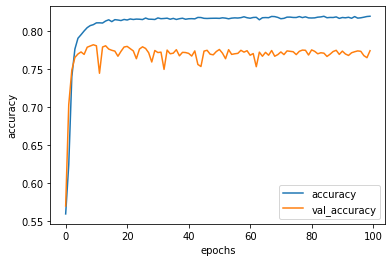

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

train_accuracy = 약 82%  

val_accuracy = 약 77%  

어휘 사전 크기를 줄였을때의 결과와 크게 다르지 않지만 임베딩 차원을 줄였기 때문에 모델 훈련 속도가 30%이상 빨라짐

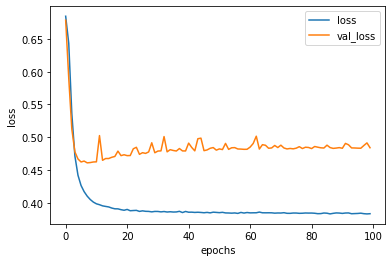

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

val_loss 그래프를 보면 10번째 epoch에서 증가하는 것처럼 보였지만 이내 평평해짐

### 모델 구조 변경하기

임베딩 차원이 7 이므로 GlobalAveragePolling1D layer가 7차원 벡터를 출력한다.  

이를 24개 뉴런으로 구성된 Dense layer에 전달해야 하는데 크기가 과도하게 큼 → 뉴런을 8개로 줄임

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [36]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6848 - accuracy: 0.5593 - val_loss: 0.6788 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6643 - accuracy: 0.5891 - val_loss: 0.6295 - val_accuracy: 0.6783
Epoch 3/100
719/719 [==============================] - 2s 3ms/step - loss: 0.5799 - accuracy: 0.7077 - val_loss: 0.5481 - val_accuracy: 0.7325
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.5064 - accuracy: 0.7574 - val_loss: 0.5017 - val_accuracy: 0.7549
Epoch 5/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4648 - accuracy: 0.7801 - val_loss: 0.4778 - val_accuracy: 0.7652
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4424 - accuracy: 0.7887 - val_loss: 0.4796 - val_accuracy: 0.7573
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.4279 - accuracy: 0.7968 - val_loss: 0.4675 - val_accuracy: 0.7660

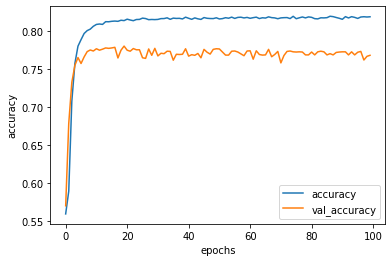

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

[임베딩 차원 바꾸기] 에서의 결과와 비슷하지만, 뉴런의 개수를 줄인 결과  

그래프의 요동이 줄어들고, 훈련 속도도 조금 빨라졌다.

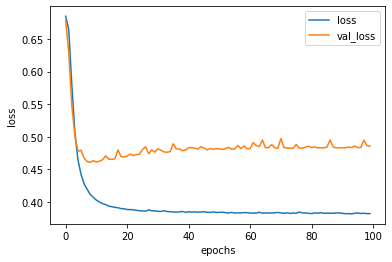

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Loss 곡선도 정확도 그래프와 같이 요동이 감소함

### Dropout 사용하기

앞선 변경 사항들이 Dropout 보다 훨씬 영향이 크다.  

Dropout 비율 = 0.25 (8개 뉴런 중 2개 해당)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [40]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6815 - accuracy: 0.5590 - val_loss: 0.6659 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6290 - accuracy: 0.6470 - val_loss: 0.5789 - val_accuracy: 0.7145
Epoch 3/100
719/719 [==============================] - 2s 3ms/step - loss: 0.5450 - accuracy: 0.7341 - val_loss: 0.5191 - val_accuracy: 0.7431
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4940 - accuracy: 0.7674 - val_loss: 0.4842 - val_accuracy: 0.7638
Epoch 5/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4638 - accuracy: 0.7840 - val_loss: 0.4726 - val_accuracy: 0.7671
Epoch 6/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4498 - accuracy: 0.7915 - val_loss: 0.4672 - val_accuracy: 0.7749
Epoch 7/100
719/719 [==============================] - 2s 3ms/step - loss: 0.4380 - accuracy: 0.7980 - val_loss: 0.4730 - val_accuracy: 0.7654

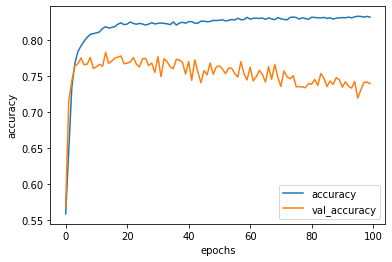

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

훈련 정확도가 이전의 최대값 이상으로 올라갔지만 검증 정확도는 천천히 감소 → Overfitting 영역에 들어감

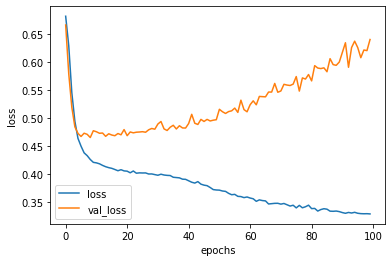

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

Epoch이 진행됨에 따라 val_loss가 증가함 → 매우 적은 뉴런을 사용할 때 드롭아웃을 추가하는 방법은 좋지 않음

### Regularization (규제) 사용하기

가중치의 크기를 감소시켜 Overfitting 방지 → 일부 뉴런의 가중치가 너무 크면 규제가 이런 가중치에 페널티 부과  

- **L1 Regularization = Lasso (라쏘)**
    
    layer의 가중치를 0 또는 0에 가까운 값으로 만듬
    
- **L2 Regularization = Ridge (리지)**
    
    0에서 먼 값과 0에 가까운 값 사이의 차이를 증폭시키기 때문에 가중치가 강하게 규제됨  

In [43]:
# Dense layer의 kernel_regularizers 매개변수를 사용해 규제 강도를 실수값으로 지정
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [44]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 4s 3ms/step - loss: 0.7074 - accuracy: 0.5596 - val_loss: 0.6858 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6861 - accuracy: 0.5596 - val_loss: 0.6831 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6846 - accuracy: 0.5596 - val_loss: 0.6808 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6796 - accuracy: 0.5596 - val_loss: 0.6730 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6645 - accuracy: 0.5842 - val_loss: 0.6537 - val_accuracy: 0.6228
Epoch 6/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6414 - accuracy: 0.6545 - val_loss: 0.6323 - val_accuracy: 0.6905
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6164 - accuracy: 0.7017 - val_loss: 0.6133 - val_accuracy: 0.7212

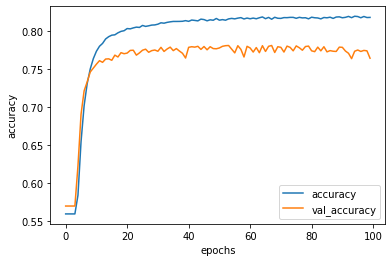

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

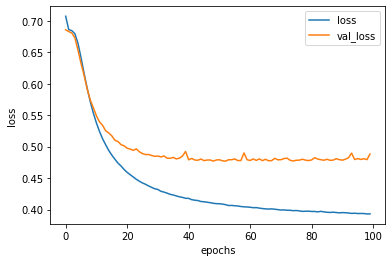

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

loss 그래프 곡선이 부드러워짐


### 다른 고려 사항 → 문장 최대 길이 바꾸기

문장의 최대 길이를 100으로 선택했지만 이는 최적이 아닐 수 있다.  

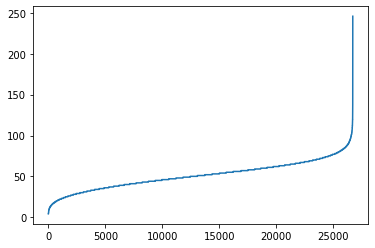

In [47]:
# 문장 길이를 짧은 것에서 긴 것까지 정렬해 그래프로 그리기
xs = []
ys = []
current_item=1
for item in sentences:
    xs.append(current_item)
    current_item=current_item+1
    ys.append(len(item))
newys = sorted(ys)

plt.plot(xs,newys)
plt.show()

전체 말뭉치에 있는 26,000개 이상의 문장 중에 단어 100개 이상을 가진 문장은 200개 미만이다.  

따라서 이 길이를 최대 길이로 선택하면 불필요한 padding을 많이 추가하게 되어 모델 성능에 영향을 미침

# 모델을 사용해 문장 분류하기

In [95]:
sentence_ex = ["granny starting to fear spiders in the garden might be real", 
             "game of thrones season finale showing this sunday night", 
             "TensorFlow book will be a best seller"]

In [96]:
sequences = tokenizer.texts_to_sequences(sentence_ex)
print(sequences)

[[1, 803, 1, 753, 1, 1, 1, 1, 312, 1, 97], [123, 1, 1183, 160, 1, 1, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1]]


< OOV > 에 해당하는 token 1 이 많다. 

'in' 과 'the' 같은 불용어는 어휘 사전에 포함되어 있지 않고, 'granny' 와 'spiders' 같은 단어는 훈련 데이터에 없는 단어이기 때문이다.

모델이 이 시퀀스를 전달하기 전에 모델이 기대하는 길이로 바꿔야 함

In [97]:
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(padded)   # max_length = 100

[[   1  803    1  753    1    1    1    1  312    1   97    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 123    1 1183  160    1    1    1 1543  152    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [51]:
print(model.predict(padded))

1/1 [==============================] - 0s 174ms/step
[[0.78173906]
 [0.04380972]
 [0.20812517]]


값이 높을 수록 빈정되는 문장일 가능성이 높다는 것을 의미한다.  

즉, "granny starting to fear spiders in the garden might be real" 문장은 빈정대는 문장이라고 볼 수 있다.

# 임베딩 시각화

word_index → 단어 : key, 인덱스 : value  

Embedding Projector로 시각화하려면 단어 : value, 인덱스 : key 로 가지기 위해 반대로 매핑해야 함 → `tokenizer.index_word` 활용

In [52]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(2000, 7)


어휘 사전 크기 = 2000 , 임베딩 차원 = 7

In [53]:
print(tokenizer.index_word[2])
print(weights[2])

new
[ 0.64279073  0.78332186 -0.94793403 -0.72860456 -0.8023105   0.7541499
  0.8700791 ]


단어 'new' 가 7개의 가중치로 구성된 벡터로 표현됨

Embedding Projector는 탭으로 구분된 두 개의 TSV (tab-separated value) 파일을 사용한다.

In [54]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = tokenizer.index_word[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

 https://projector.tensorflow.org/ 에서 meta.tsv, vecs.tsv 파일을 로드하고 구(sphere)로 클러스터링한 결과

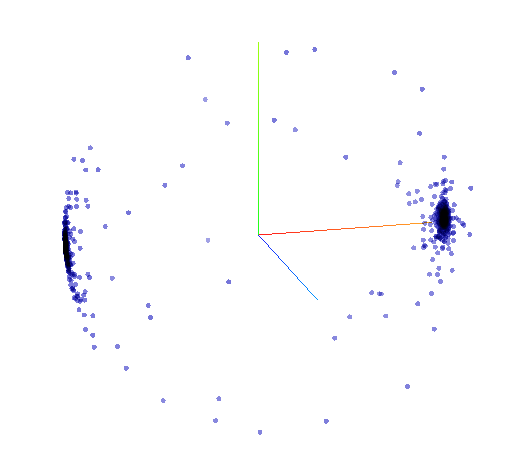

# Tensorflow Hub에서 사전 훈련된 임베딩 사용하기

Keras layer에 적합하도록 사전 훈련된 임베딩 사용  

Tokenizer logic을 제공하는 경우 tokenizer, sequence 생성, padding 직접 처리할 필요 X

In [85]:
with open("../ch06/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [86]:
training_size = 23000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [90]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", 
    output_shape=[20], input_shape=[], 
    dtype=tf.string, trainable=False
)

위의 layer는 문장을 인코딩, 토큰화하고 단어와 Swivel 임베딩을 사용해 **문장을 하나의 임베딩**으로 인코딩한다.  

지금까지는 단어 인코딩을 사용해 이를 기반으로 문장을 분류했으나, 이 layer를 사용하면 전체 문장을 하나의 인코딩으로 만들 수 있다.

In [91]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])

In [92]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_20 (Dense)            (None, 16)                336       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


넘파이 배열로 바뀐 레이블을 다시 리스트로 변경

In [93]:
training_labels = list(training_labels)
testing_labels = list(testing_labels)

In [94]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs, validation_data=(testing_sentences, testing_labels))

Epoch 1/50
719/719 [==============================] - 3s 3ms/step - loss: 0.7677 - accuracy: 0.4657 - val_loss: 0.7257 - val_accuracy: 0.4894
Epoch 2/50
719/719 [==============================] - 2s 3ms/step - loss: 0.7066 - accuracy: 0.5135 - val_loss: 0.6920 - val_accuracy: 0.5489
Epoch 3/50
719/719 [==============================] - 2s 3ms/step - loss: 0.6835 - accuracy: 0.5628 - val_loss: 0.6747 - val_accuracy: 0.5899
Epoch 4/50
719/719 [==============================] - 2s 3ms/step - loss: 0.6702 - accuracy: 0.5990 - val_loss: 0.6652 - val_accuracy: 0.6074
Epoch 5/50
719/719 [==============================] - 2s 3ms/step - loss: 0.6620 - accuracy: 0.6131 - val_loss: 0.6594 - val_accuracy: 0.6115
Epoch 6/50
719/719 [==============================] - 2s 3ms/step - loss: 0.6565 - accuracy: 0.6210 - val_loss: 0.6555 - val_accuracy: 0.6193
Epoch 7/50
719/719 [==============================] - 2s 3ms/step - loss: 0.6527 - accuracy: 0.6240 - val_loss: 0.6521 - val_accuracy: 0.6239
Epoch 

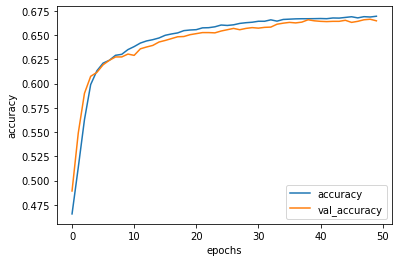

In [98]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

Overfitting 이 크게 일어나지 않음  

단어 기반 인코딩을 하나의 문장 기반 인코딩으로 바꿨기 때문에 정확도는 약 67%로 매우 낮다.

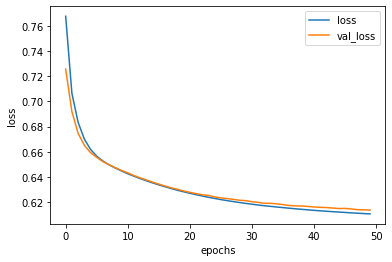

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

loss 값도 매우 근접하며 훈련이 잘 됨  

빈정되는 헤드라인을 구분하는 경우 개별 단어가 분류에 큰 영향을 미침

따라서 사전 훈련된 임베딩을 사용하면 훈련이 빠르고 Overfitting이 적지만 어떤 상황에 유용한지 생각해야 함